# Решающие деревья для донорского молока


In [85]:
import numpy as np
import pandas as pd # conda install -c anaconda pandas
import seaborn as sns
import matplotlib.pyplot as plt

### Загрузка данных

В ходе задания будем использовать __train_data.csv__ для обучения моделей, на нем же и будем производить кросс-валидацию. В качестве отложенной выборки будем использовать __test_data.csv__

In [2]:
column_names = ["Targ1","Targ2","Targ3","Targ4","Don","Apgar","Sex","Vospal","Ves",
                "IMT","Somat","Ob_somat","Ob_gin","Ob_inf_ber","Ob_inf_lac","ZMG_lac",
                "Prer_ber","Gestoz","AB_ber","AB_lac","Prob_lac","Rody","7_St aureus","7_Klebsiella","7_E.Coli",
                "7_S.epidermidis","7_Enterococcus spp.","7_S.salivarius","7_K.pneumoniae","7_S. haemolyticus/hominis",
                "7_S. lugdunensis","7_A.pittii","7_S. agalactiae","7_S. anginosus","7_A. baumannii","7_Kocuria kristinae",
                "7_Rothia spp.","7_Corynebacterium spp.","7_Enterobacter spp.","7_A.junii","7_S.maltophilia","7_R.aquatilis",
                "7_Pseudomonas spp","7_E. faecalis","4_St aureus","4_Klebsiella","4_E.Coli","4_S.epidermidis",
                "4_Enterococcus spp.","4_S.salivarius","4_K.pneumoniae","4_S. haemolyticus/hominis",
                "4_S. lugdunensis ","4_A.pittii","4_S. agalactiae","4_S. anginosus","4_A. baumannii","4_Kocuria kristinae",
                "4_Rothia spp.","4_Corynebacterium spp.","4_Enterobacter spp.","4_A.junii","4_S.maltophilia",
                "4_R.aquatilis","4_Pseudomonas spp","4_E. faecalis","10_St aureus","10_Klebsiella",
                "10_E.Coli","10_S.epidermidis","10_Enterococcus spp.","10_S.salivarius","10_K.pneumoniae",
                "10_S. haemolyticus/hominis","10_S. lugdunensis ","10_A.pittii","10_S. agalactiae",
                "10_S. anginosus","10_A. baumannii","10_Kocuria kristinae","10_Rothia spp.",
                "10_Corynebacterium spp.","10_Enterobacter spp.","10_A.junii","10_S.maltophilia",
                "10_R.aquatilis","10_Pseudomonas spp","10_E. faecalis"]

In [3]:
train = pd.read_csv("DM2_train.csv", sep=";", header=None, engine="python", names=column_names)

In [4]:
test = pd.read_csv("DM3_test.csv", sep=";", header=None, engine="python", names=column_names)

### 0. Перекодировка категориальных данных в численные

Учтите, что целевая переменная в датасете является строкой. Поэтому для начала ее нужно перевести в бинарную величину. 

In [5]:
train.shape

(41, 88)

In [6]:
test.shape

(20, 88)

In [7]:
train.head()

,Targ1,Targ2,Targ3,Targ4,Don,Apgar,Sex,Vospal,Ves,IMT,...,10_A. baumannii,10_Kocuria kristinae,10_Rothia spp.,10_Corynebacterium spp.,10_Enterobacter spp.,10_A.junii,10_S.maltophilia,10_R.aquatilis,10_Pseudomonas spp,10_E. faecalis
0,1,1,0,0,0,2,2,0,3,2,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,2,1,4,2,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,2,2,1,5,3,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,2,1,1,6,3,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,2,1,0,4,3,...,0,0,0,0,0,0,0,0,0,0


In [54]:
numeric_cols = ["Targ1","Don","Apgar","Sex","Vospal","Ves",
                "IMT","Somat","Ob_somat","Ob_gin","Ob_inf_ber","Ob_inf_lac","ZMG_lac",
                "Prer_ber","Gestoz","AB_ber","AB_lac","Prob_lac","Rody"]
numeric_cols

['Targ1',
 'Don',
 'Apgar',
 'Sex',
 'Vospal',
 'Ves',
 'IMT',
 'Somat',
 'Ob_somat',
 'Ob_gin',
 'Ob_inf_ber',
 'Ob_inf_lac',
 'ZMG_lac',
 'Prer_ber',
 'Gestoz',
 'AB_ber',
 'AB_lac',
 'Prob_lac',
 'Rody']

In [55]:
numeric_cols_X = ["Don","Apgar","Sex","Vospal","Ves",
                "IMT","Somat","Ob_somat","Ob_gin","Ob_inf_ber","Ob_inf_lac","ZMG_lac",
                "Prer_ber","Gestoz","AB_ber","AB_lac","Prob_lac","Rody"]
numeric_cols_Y = ["Targ1"]

In [10]:
train[numeric_cols_X].head()

,Don,Apgar,Sex,Vospal,Ves,IMT,Somat,Ob_somat,Ob_gin,Ob_inf_ber,Ob_inf_lac,ZMG_lac,Prer_ber,Gestoz,AB_ber,AB_lac,Prob_lac,Rody
0,0,2,2,0,3,2,0,0,0,1,0,0,0,0,1,0,0,2
1,0,1,2,1,4,2,1,0,0,1,0,0,0,1,0,0,0,1
2,1,2,2,1,5,3,1,1,1,0,0,0,1,1,0,0,0,2
3,1,2,1,1,6,3,0,0,0,1,0,0,0,0,0,0,0,1
4,0,2,1,0,4,3,1,0,0,0,0,0,1,0,0,0,0,2


In [13]:
train[numeric_cols_Y].head()

,Targ1
0,1
1,1
2,1
3,1
4,1


In [16]:
#new_train.to_csv('train_data_1.csv')
#new_test.to_csv('test_data_1.csv')

### 1.1. Проверка базы на сбалансированность  

In [15]:
#статистика признаков - делается только по численным признакам
train[numeric_cols_X].describe()

,Don,Apgar,Sex,Vospal,Ves,IMT,Somat,Ob_somat,Ob_gin,Ob_inf_ber,Ob_inf_lac,ZMG_lac,Prer_ber,Gestoz,AB_ber,AB_lac,Prob_lac,Rody
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.536585,1.463415,1.463415,0.268293,4.195122,2.195122,0.512195,0.073171,0.146341,0.292683,0.073171,0.024390,0.463415,0.195122,0.170732,0.146341,0.024390,1.487805
std,0.504854,0.504854,0.504854,0.448575,1.382380,0.510858,0.506061,0.263652,0.357839,0.460646,0.263652,0.156174,0.504854,0.401218,0.380949,0.357839,0.156174,0.506061
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,1.000000,0.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.000000,2.000000,1.000000,5.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,2.000000,2.000000,1.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [16]:
test[numeric_cols_X].describe()

,Don,Apgar,Sex,Vospal,Ves,IMT,Somat,Ob_somat,Ob_gin,Ob_inf_ber,Ob_inf_lac,ZMG_lac,Prer_ber,Gestoz,AB_ber,AB_lac,Prob_lac,Rody
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.300000,1.450000,1.35000,0.200000,4.000000,2.000000,0.35000,0.050000,0.150000,0.400000,0.150000,0.100000,0.500000,0.600000,0.050000,0.050000,0.050000,1.400000
std,0.470162,0.604805,0.48936,0.410391,1.450953,0.725476,0.48936,0.223607,0.366348,0.502625,0.366348,0.307794,0.512989,0.502625,0.223607,0.223607,0.223607,0.502625
min,0.000000,1.000000,1.00000,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.00000,0.000000,4.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.00000,0.000000,4.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.000000,2.00000,0.000000,5.000000,2.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000
max,1.000000,3.000000,2.00000,1.000000,6.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [38]:
#Построение пивотов
#train.pivot_table(['capital-gain'], ['age'], aggfunc='sum', fill_value = 0)
#train.pivot_table(['Targ2'], ['class'], aggfunc='count', fill_value = 0)

In [39]:
#test.pivot_table(['class_n'], ['class'], aggfunc='count', fill_value = 0)

In [17]:
import matplotlib.pyplot as plt

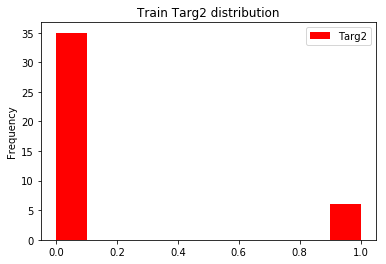

In [40]:
#train.plot(y='Targ2', kind='hist', color='red',  title='Train Targ2 distribution')
#plt.show()

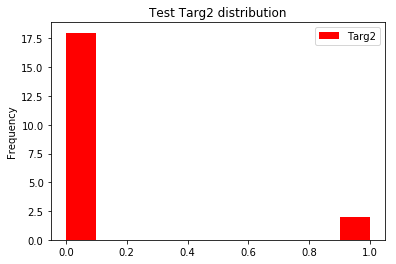

In [41]:
#test.plot(y='Targ2', kind='hist', color='red',  title='Test Targ2 distribution')
#plt.show()

Выборка обучающая и тестовая несбалансированы.

In [18]:
new_train = train
new_test = test

### 2. Обучение на вещественных признаках

В этом разделе обучите модели только на вещественных признаках ("continuous" в описании данных). Обучите логистическую регрессию (linear_model.LogisticRegression) и случайный лес (ensemble.RandomForestClassifier) из sklearn. В первом случае подберите оптимальные параметры $penalty$ и $C$ на отрезке $[10^{-6}, 10^{6}]$ (по степеням $10$ с шагом $1$, начиная с $-6$), а во втором при фиксированном числе деревьев в 50 подберите $max\_depth$ и $min\_samples\_split$ из отрезка $[2, 14]$ с шагом в 2 и множества $\{1, 2, 4, 8\}$ соответственно. За целевую метрику качества возьмите AUC-ROC. В качестве схемы валидации используйте стратифицированную кросс-валидацию по 5-ти фолдам. Какие параметры оказались оптимальными?

Учтите, что целевая переменная в датасете является строкой. Поэтому для начала ее нужно перевести в бинарную величину. Также не забудьте отмасштабировать данные с помощью StandartScaler'а из модуля preprocessing.

### Логистическая регрессия (linear_model.LogisticRegression) 
В первом случае подберите оптимальные параметры  $penalty$ и $C$ на отрезке $[10^{-6}, 10^{6}]$ (по степеням $10$ с шагом $1$, начиная с $-6$)

Увеличивая $C$, мы тем самым мы ослабляем регуляризацию. Когда регуляризации явно недостаточно, то мы наблюдаем переобучение.

Чем больше параметр $C$, тем более сложные зависимости в данных может восстанавливать модель (интуитивно $C$ соответствует "сложности" модели (model capacity))

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [39]:
clfs = [LogisticRegression(C=0.000001,penalty='l1', random_state=10),
        LogisticRegression(C=0.00001,penalty='l1', random_state=10),
        LogisticRegression(C=0.0001,penalty='l1', random_state=10),
        LogisticRegression(C=0.001,penalty='l1', random_state=10),
        LogisticRegression(C=0.01,penalty='l1', random_state=10),
        LogisticRegression(C=0.1,penalty='l1', random_state=10),
        LogisticRegression(C=1,penalty='l1', random_state=10),
        LogisticRegression(C=10,penalty='l1', random_state=10),
        LogisticRegression(C=100,penalty='l1', random_state=10),
        LogisticRegression(C=1000,penalty='l1', random_state=10),
        LogisticRegression(C=10000,penalty='l1', random_state=10),
        LogisticRegression(C=100000,penalty='l1', random_state=10),
        LogisticRegression(C=1000000,penalty='l1', random_state=10),
        LogisticRegression(C=0.000001,penalty='l2', random_state=10),
        LogisticRegression(C=0.00001,penalty='l2', random_state=10),
        LogisticRegression(C=0.0001,penalty='l2', random_state=10),
        LogisticRegression(C=0.001,penalty='l2', random_state=10),
        LogisticRegression(C=0.01,penalty='l2', random_state=10),
        LogisticRegression(C=0.1,penalty='l2', random_state=10),
        LogisticRegression(C=1,penalty='l2', random_state=10),
        LogisticRegression(C=10,penalty='l2', random_state=10),
        LogisticRegression(C=100,penalty='l2', random_state=10),
        LogisticRegression(C=1000,penalty='l2', random_state=10),
        LogisticRegression(C=10000,penalty='l2', random_state=10),
        LogisticRegression(C=100000,penalty='l2', random_state=10),
        LogisticRegression(C=1000000,penalty='l2', random_state=10)]

In [21]:
type(clfs[0])

sklearn.linear_model.logistic.LogisticRegression

In [40]:
clfs_x = np.array(['C=0.000001,penalty=l1',
          'C=0.00001,penalty=l1',
          'C=0.0001,penalty=l1',
          'C=0.001,penalty=l1',
          'C=0.01,penalty=l1',
          'C=0.1,penalty=l1',
          'C=1,penalty=l1',
          'C=10,penalty=l1',
          'C=100,penalty=l1',
          'C=1000,penalty=l1',
          'C=10000,penalty=l1',
          'C=100000,penalty=l1',
          'C=1000000,penalty=l1',
          'C=0.000001,penalty=l2',
          'C=0.00001,penalty=l2',
          'C=0.0001,penalty=l2',
          'C=0.001,penalty=l2',
          'C=0.01,penalty=l2',
          'C=0.1,penalty=l2',
          'C=1,penalty=l2',
          'C=10,penalty=l2',
          'C=100,penalty=l2',
          'C=1000,penalty=l2',
          'C=10000,penalty=l2',
          'C=100000,penalty=l2',
          'C=1000000,penalty=l2'])

In [41]:
clfs_n = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26])

In [42]:
train_Accuracy = np.zeros(len(clfs))
train_Precision = np.zeros(len(clfs))
train_Recall = np.zeros(len(clfs))
train_Roc_auc = np.zeros(len(clfs))
train_F1 = np.zeros(len(clfs))
#train_Accuracy.shape

In [43]:
for j, clf in enumerate(clfs):
    #print (j, clf)
    clf.fit(new_train[numeric_cols_X], new_train[numeric_cols_Y])
    train_Accuracy[j] = np.mean(cross_val_score(clf, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='accuracy'))
    train_Precision[j] = np.mean(cross_val_score(clf, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='precision'))
    train_Recall[j] = np.mean(cross_val_score(clf, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='recall'))
    train_Roc_auc[j] = np.mean(cross_val_score(clf, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='roc_auc'))
    train_F1[j] = np.mean(cross_val_score(clf, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='f1'))

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A colum

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: Fu

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y w

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: Futu

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\skle

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\skle

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A colum

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A colum

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A colum

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y w

In [44]:
for j, clf in enumerate(clfs):
    print ('Accuracy', j, train_Accuracy[j])
    print ('Precision', j, train_Precision[j])
    print ('Recall', j, train_Recall[j])
    print ('Roc_auc', j, train_Roc_auc[j])
    print ('F1', j, train_F1[j])
    print (' ')

Accuracy 0 0.36630036630036633
Precision 0 0.0
Recall 0 0.0
Roc_auc 0 0.5
F1 0 0.0
 
Accuracy 1 0.36630036630036633
Precision 1 0.0
Recall 1 0.0
Roc_auc 1 0.5
F1 1 0.0
 
Accuracy 2 0.36630036630036633
Precision 2 0.0
Recall 2 0.0
Roc_auc 2 0.5
F1 2 0.0
 
Accuracy 3 0.36630036630036633
Precision 3 0.0
Recall 3 0.0
Roc_auc 3 0.5
F1 3 0.0
 
Accuracy 4 0.36630036630036633
Precision 4 0.0
Recall 4 0.0
Roc_auc 4 0.5
F1 4 0.0
 
Accuracy 5 0.6336996336996338
Precision 5 0.6336996336996338
Recall 5 1.0
Roc_auc 5 0.5680555555555555
F1 5 0.7757073844030367
 
Accuracy 6 0.5860805860805861
Precision 6 0.6223776223776224
Recall 6 0.8888888888888888
Roc_auc 6 0.49259259259259264
F1 6 0.7297258297258299
 
Accuracy 7 0.5842490842490843
Precision 7 0.7361111111111112
Recall 7 0.6620370370370371
Roc_auc 7 0.48518518518518516
F1 7 0.6675070028011204
 
Accuracy 8 0.6135531135531136
Precision 8 0.6888528138528139
Recall 8 0.7037037037037037
Roc_auc 8 0.5574074074074074
F1 8 0.6851135190918473
 
Accuracy 9 0

In [27]:
max_Accuracy = max(train_Accuracy)
ind_Accuracy = np.where(train_Accuracy == max_Accuracy)
#IA = int(ind_Accuracy[0][0])
for a, b in enumerate(ind_Accuracy[0]):
    #print('a= ', a, 'b= ',b)
    print ('Optimal method: ' + str (b) + ' ' + str(clfs_x[b]) + ' Accuracy = '+ str(max_accuracy))

NameError: name 'max_accuracy' is not defined

In [113]:
max_Precision = max(train_Precision)
ind_Precision = np.where(train_Precision == max_Precision)
#IA = int(ind_Precision[0][0])
#print(len(ind_Precision[0]))
for a, b in enumerate(ind_Precision[0]):
    #print('a= ', a, 'b= ',b)
    print ('Optimal method: ' + str (b) + ' ' + str(clfs_x[b]) + ' Precision = '+ str(max_Precision))

Optimal method: 0 C=0.000001,penalty=l1 Precision = 0.8212434372617926


In [114]:
max_Recall = max(train_Recall)
ind_Recall = np.where(train_Recall == max_Recall)
#IA = int(ind_Recall[0][0])
#print(len(ind_Recall[0]))
for a, b in enumerate(ind_Recall[0]):
    #print('a= ', a, 'b= ',b)
    print ('Optimal method: ' + str (b) + ' ' + str(clfs_x[b]) + ' Recall = '+ str(max_Recall))

Optimal method: 9 C=1000,penalty=l1 Recall = 0.3875790060741356
Optimal method: 10 C=10000,penalty=l1 Recall = 0.3875790060741356
Optimal method: 11 C=100000,penalty=l1 Recall = 0.3875790060741356
Optimal method: 12 C=1000000,penalty=l1 Recall = 0.3875790060741356


In [115]:
max_Roc_auc = max(train_Roc_auc)
ind_Roc_auc = np.where(train_Roc_auc == max_Roc_auc)
#IA = int(ind_Roc_auc[0][0])
#print(len(ind_Roc_auc[0]))
for a, b in enumerate(ind_Roc_auc[0]):
    #print('a= ', a, 'b= ',b)
    print ('Optimal method: ' + str (b) + ' ' + str(clfs_x[b]) + ' Roc_auc = '+ str(max_Roc_auc))

Optimal method: 11 C=100000,penalty=l1 Roc_auc = 0.831505862819521
Optimal method: 12 C=1000000,penalty=l1 Roc_auc = 0.831505862819521


In [116]:
max_F1 = max(train_F1)
ind_F1 = np.where(train_F1 == max_F1)
#IA = int(ind_F1[0][0])
#print(len(ind_F1[0]))
for a, b in enumerate(ind_F1[0]):
    #print('a= ', a, 'b= ',b)
    print ('Optimal method: ' + str (b) + ' ' + str(clfs_x[b]) + ' F1 = '+ str(max_F1))

Optimal method: 9 C=1000,penalty=l1 F1 = 0.5025158821866132
Optimal method: 10 C=10000,penalty=l1 F1 = 0.5025158821866132
Optimal method: 11 C=100000,penalty=l1 F1 = 0.5025158821866132
Optimal method: 12 C=1000000,penalty=l1 F1 = 0.5025158821866132


Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.0, 'Choosing Optimal method')

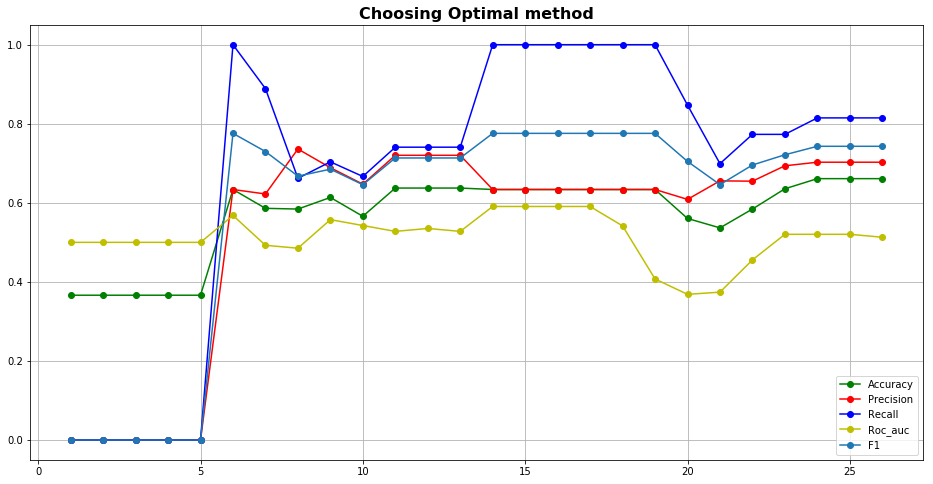

In [45]:
%pylab inline
fig, ax = plt.subplots(figsize=(16,8))
pylab.grid(True)
pylab.plot(clfs_n, train_Accuracy, 'g-', marker='o', label='Accuracy')
pylab.plot(clfs_n, train_Precision, 'r-', marker='o', label='Precision')
pylab.plot(clfs_n, train_Recall, 'b-', marker='o', label='Recall')
pylab.plot(clfs_n, train_Roc_auc, 'y-', marker='o', label='Roc_auc')
pylab.plot(clfs_n, train_F1, 'p-', marker='o', label='F1')
#pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')
ax.set_title('Choosing Optimal method', fontsize = 16, fontweight='bold', color='black')

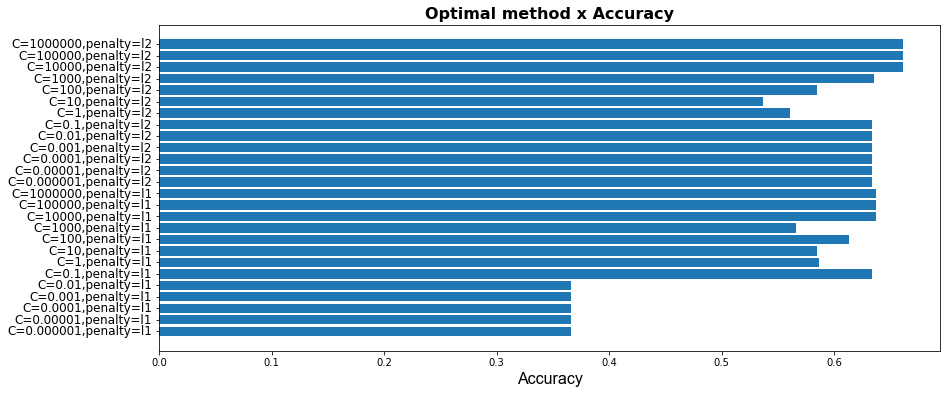

In [29]:
# http://pyprog.pro/mpl/mpl_signatures_of_divisions.html

fig, ax = plt.subplots(figsize=(14,6))
ax.barh(clfs_x, train_Accuracy)
position = np.arange(len(clfs_x))
ax.set_yticks(position)
ax.set_yticklabels(clfs_x, fontsize = 12, color = 'black', rotation = 0, verticalalignment =  'center')
ax.set_title('Optimal method x Accuracy', fontsize = 16, fontweight='bold', color='black')
plt.xlabel('Accuracy',{'fontname':'Arial'}, fontsize = 16)
#plt.text(0.5, 0.5, 'Text in relative coords', fontsize=14,
#         horizontalalignment='right', verticalalignment='center',
#         transform=ax.transAxes)
#plt.annotate() # добавляет примечание, которое состоит из текста и необязательной стрелки в указанную область на рисунке 
plt.show()

## Посчитайте accuracy, precision, recall, f1-score и AUC-ROC (Площадь под кривой) на отложенной выборке для оптимальных алгоритмов

In [46]:
train_Accuracy_p = np.zeros(len(clfs))
train_Precision_p = np.zeros(len(clfs))
train_Recall_p = np.zeros(len(clfs))
train_Roc_auc_p = np.zeros(len(clfs))
train_F1_p = np.zeros(len(clfs))

In [47]:
for j, clf in enumerate(clfs):
    print (j, clf)
    prediction = clf.predict(new_test[numeric_cols_X])
    #clf.fit(new_train[numeric_cols_X], new_train[numeric_cols_Y])
    #Измерение точности предсказания - доля
    train_Accuracy_p[j] = np.mean(accuracy_score(new_test[numeric_cols_Y], prediction))
    train_Precision_p[j] = np.mean(precision_score(new_test[numeric_cols_Y], prediction))
    train_Recall_p[j] = np.mean(recall_score(new_test[numeric_cols_Y], prediction))
    train_Roc_auc_p[j] = np.mean(roc_auc_score(new_test[numeric_cols_Y], prediction))
    train_F1_p[j] = np.mean(f1_score(new_test[numeric_cols_Y], prediction))
    print('accuracy: ', train_Accuracy_p[j])
    print('precision: ', train_Precision_p[j])
    print('recall: ', train_Recall_p[j])
    print('roc_auc: ', train_Roc_auc_p[j])
    print('F1: ', train_F1_p[j])

0 LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy:  0.65
precision:  0.0
recall:  0.0
roc_auc:  0.5
F1:  0.0
1 LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=10, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
accuracy:  0.65
precision:  0.0
recall:  0.0
roc_auc:  0.5
F1:  0.0
2 LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=10,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
accuracy:  0.65
precision:  0.0
recall:  0.0
roc_auc:  0.5
F1:  0

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to

accuracy:  0.55
precision:  0.4
recall:  0.5714285714285714
roc_auc:  0.554945054945055
F1:  0.47058823529411764
11 LogisticRegression(C=100000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=10,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
accuracy:  0.55
precision:  0.4
recall:  0.5714285714285714
roc_auc:  0.554945054945055
F1:  0.47058823529411764
12 LogisticRegression(C=1000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=10,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
accuracy:  0.55
precision:  0.4
recall:  0.5714285714285714
roc_auc:  0.554945054945055
F1:  0.47058823529411764
13 LogisticRegression(C=1e-06, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10

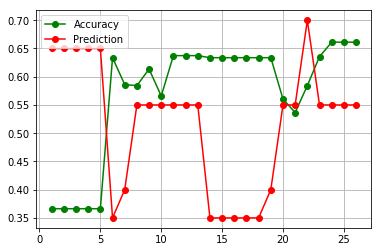

In [32]:
fig, ax = plt.subplots(figsize=(6,4))
pylab.grid(True)
pylab.plot(clfs_n, train_Accuracy, 'g-', marker='o', label='Accuracy')
pylab.plot(clfs_n, train_Accuracy_p, 'r-', marker='o', label='Prediction')
pylab.legend()

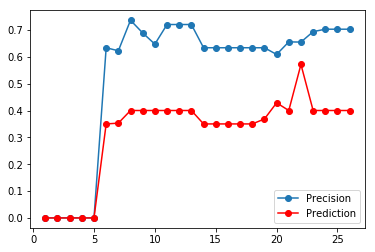

In [33]:
pylab.plot(clfs_n, train_Precision, 's-', marker='o', label='Precision')
pylab.plot(clfs_n, train_Precision_p, 'r-', marker='o', label='Prediction')
pylab.legend()

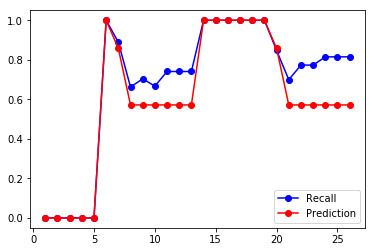

In [34]:
pylab.plot(clfs_n, train_Recall, 'b-', marker='o', label='Recall')
pylab.plot(clfs_n, train_Recall_p, 'r-', marker='o', label='Prediction')
pylab.legend()

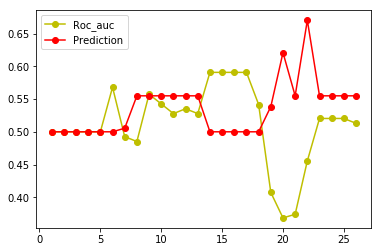

In [35]:
pylab.plot(clfs_n, train_Roc_auc, 'y-', marker='o', label='Roc_auc')
pylab.plot(clfs_n, train_Roc_auc_p, 'r-', marker='o', label='Prediction')
pylab.legend()

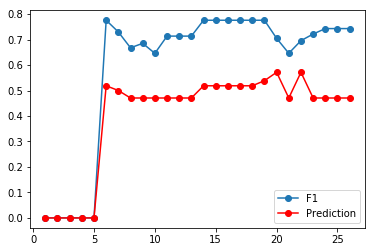

In [36]:
pylab.plot(clfs_n, train_F1, 'p-', marker='o', label='F1')
pylab.plot(clfs_n, train_F1_p, 'r-', marker='o', label='Prediction')
pylab.legend()

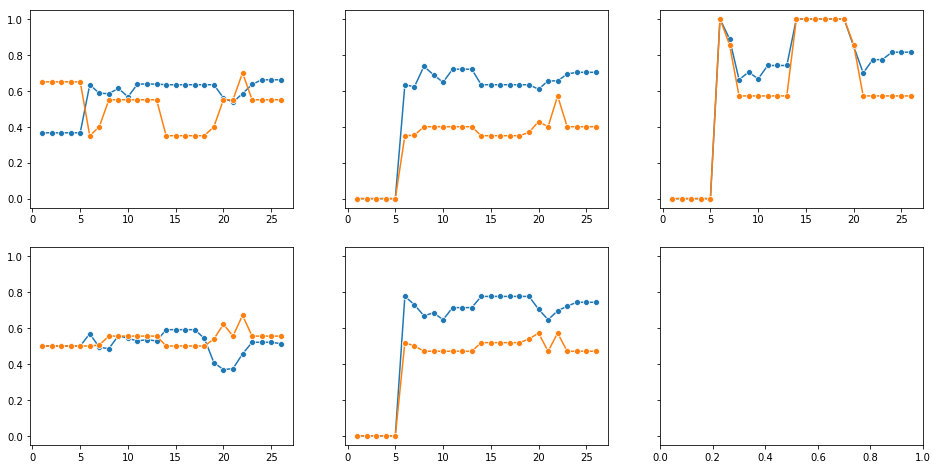

In [37]:
 _, axes = plt.subplots(2, 3, sharey=True, figsize=(16,8))

sns.lineplot(clfs_n, train_Accuracy, marker='o', legend='full', ax=axes[0][0])
sns.lineplot(clfs_n, train_Accuracy_p, marker='o', legend='full', ax=axes[0][0])

sns.lineplot(clfs_n, train_Precision, marker='o', legend='full', ax=axes[0][1])
sns.lineplot(clfs_n, train_Precision_p, marker='o', legend='full', ax=axes[0][1])

sns.lineplot(clfs_n, train_Recall, marker='o', legend='full', ax=axes[0][2])
sns.lineplot(clfs_n, train_Recall_p, marker='o', legend='full', ax=axes[0][2])

sns.lineplot(clfs_n, train_Roc_auc, marker='o', legend='full', ax=axes[1][0])
sns.lineplot(clfs_n, train_Roc_auc_p, marker='o', legend='full', ax=axes[1][0])

sns.lineplot(clfs_n, train_F1, marker='o', legend='full', ax=axes[1][1])
sns.lineplot(clfs_n, train_F1_p, marker='o', legend='full', ax=axes[1][1])


plt.show();

### Настройка параметра регуляризации

Теперь найдем оптимальное (в данном примере) значение параметра регуляризации . Сделать это можно с помощью LogisticRegressionCV – перебора параметров по сетке с последующей кросс-валидацией. Этот класс создан специально для логистической регрессии (для нее известны эффективные алгоритмы перебора параметров), для произвольной модели мы бы использовали GridSearchCV, RandomizedSearchCV или, например, специальные алгоритмы оптимизации гиперпараметров, реализованные в hyperopt. https://habr.com/ru/company/ods/blog/323890/#2-logisticheskaya-regressiya

Такие кривые называются валидационными, раньше мы их строили вручную, но в sklearn для них их построения есть специальные методы, которые мы тоже сейчас будем использовать.

# Визуализация данных

+ смотри http://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

In [66]:
from matplotlib import pyplot as plt
%matplotlib inline

In [68]:
new_train['Targ2'].value_counts()

0    35
1     6
Name: Targ2, dtype: int64

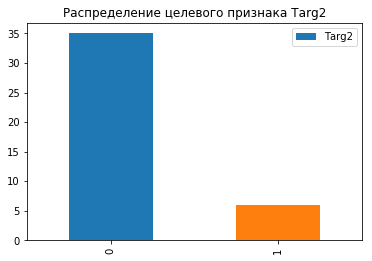

In [70]:
new_train['Targ2'].value_counts().plot(kind='bar', rot = 90)
plt.legend()
plt.title(u'Распределение целевого признака Targ2');

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

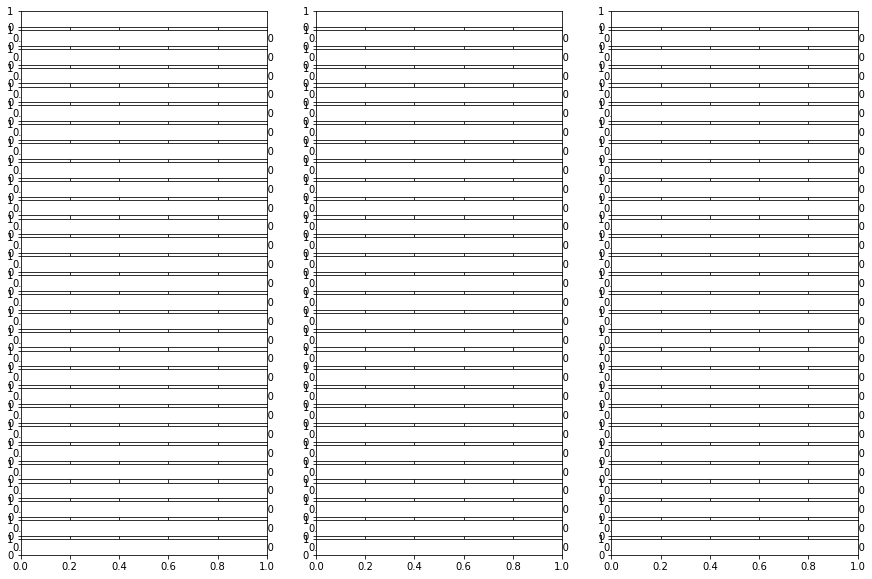

In [74]:
fig, axes = plt.subplots(nrows=29, ncols=3, figsize=(15, 10))
for idx, feature in enumerate(new_train[numeric_cols].columns[:-1]):
    new_train.plot(feature, "Targ2", subplots=True, kind="scatter", ax=axes[idx / 3, idx % 3])

In [77]:
# Графики всех численных переменных со всеми

sns_plot = sns.pairplot(new_train[numeric_cols])
# Сохранение графиков в файл .png
sns_plot.savefig('pairplot.png')


# Сохранение графиков в формате html
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#import plotly
#import plotly.graph_objs as go
#init_notebook_mode(connected=True)
#plotly.offline.plot(sns_plot, filename='years_stats.html', show_link=False)

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


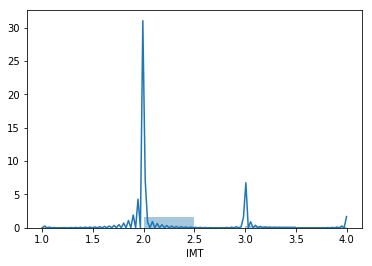

In [78]:
# Постороение гистограмм распределения
sns.distplot(new_train.IMT)

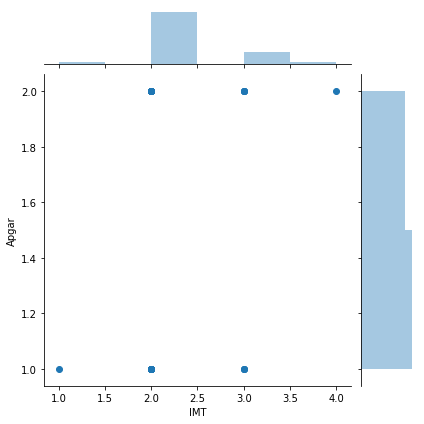

In [79]:
# Для того, чтобы подробнее посмотреть на взаимосвязь двух численных признаков, 
# есть еще и joint plot — это гибрид scatter plot и histogram.
sns.jointplot(x="IMT", y="Apgar", data=new_train[numeric_cols])

# http://seaborn.pydata.org/generated/seaborn.jointplot.html Здесь есть еще другие графики

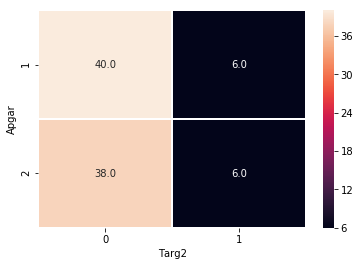

In [80]:
# Heat map позволяет посмотреть на распределение какого-то численного признака по двум категориальным. Визуализируем суммарные 
platform_genre_sales = new_train.pivot_table(
                        index='Apgar', 
                        columns='Targ2', 
                        values='IMT', 
                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(platform_genre_sales, annot=True, fmt=".1f", linewidths=.5)

In [126]:
# НЕ РАБОТАЕТ пока(
#from pandas.plotting import parallel_coordinates
#plt.figure()
#parallel_coordinates(new_train[numeric_cols_Y], 'class_n', colormap='gist_rainbow')

In [48]:
# Выборка по фильтру class_n==1
new_test[new_test.Targ1==1]

,Targ1,Targ2,Targ3,Targ4,Don,Apgar,Sex,Vospal,Ves,IMT,...,10_A. baumannii,10_Kocuria kristinae,10_Rothia spp.,10_Corynebacterium spp.,10_Enterobacter spp.,10_A.junii,10_S.maltophilia,10_R.aquatilis,10_Pseudomonas spp,10_E. faecalis
1,1,0,0,0,1,1,2,1,5,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,1,0,4,1,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,2,1,0,6,4,...,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,1,1,1,0,5,2,...,0,0,0,0,0,0,0,0,0,0
12,1,0,0,0,0,2,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
13,1,0,0,0,1,1,1,0,6,1,...,0,0,0,0,0,0,0,0,0,0
18,1,0,0,0,0,3,2,1,1,2,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Столбец Возраст по фильтру класс = 1
new_test[new_test.Targ1==1].Apgar

1     1
2     1
7     2
11    1
12    2
13    1
18    3
Name: Apgar, dtype: int64

In [50]:
new_train_corrw=new_train.loc[:,new_train.columns[4:22]].corrwith(new_train.loc[:,'Targ1'])
new_train_corrw

Don           0.106500
Apgar        -0.106500
Sex           0.299685
Vospal        0.345647
Ves           0.219798
IMT          -0.007343
Somat        -0.133425
Ob_somat     -0.175476
Ob_gin       -0.115311
Ob_inf_ber    0.266014
Ob_inf_lac    0.018970
ZMG_lac      -0.208167
Prer_ber      0.096593
Gestoz       -0.009349
AB_ber        0.075493
AB_lac       -0.115311
Prob_lac      0.120096
Rody          0.032121
dtype: float64

In [51]:
new_train_corrw=new_train.loc[:,new_train.columns[23:44]].corrwith(new_train.loc[:,'Targ1'])
new_train_corrw

7_Klebsiella                 0.120096
7_E.Coli                     0.120096
7_S.epidermidis              0.616952
7_Enterococcus spp.          0.244383
7_S.salivarius               0.172005
7_K.pneumoniae                    NaN
7_S. haemolyticus/hominis         NaN
7_S. lugdunensis             0.120096
7_A.pittii                   0.199609
7_S. agalactiae              0.120096
7_S. anginosus                    NaN
7_A. baumannii               0.120096
7_Kocuria kristinae          0.120096
7_Rothia spp.                     NaN
7_Corynebacterium spp.            NaN
7_Enterobacter spp.         -0.208167
7_A.junii                    0.120096
7_S.maltophilia              0.120096
7_R.aquatilis                0.120096
7_Pseudomonas spp                 NaN
7_E. faecalis                     NaN
dtype: float64

In [52]:
new_train_corrw=new_train.loc[:,new_train.columns[45:66]].corrwith(new_train.loc[:,'Targ1'])
new_train_corrw

4_Klebsiella                 0.120096
4_E.Coli                     0.120096
4_S.epidermidis              0.654894
4_Enterococcus spp.          0.266081
4_S.salivarius               0.172005
4_K.pneumoniae                    NaN
4_S. haemolyticus/hominis         NaN
4_S. lugdunensis             0.120096
4_A.pittii                   0.208867
4_S. agalactiae              0.120096
4_S. anginosus                    NaN
4_A. baumannii               0.120096
4_Kocuria kristinae          0.120096
4_Rothia spp.                     NaN
4_Corynebacterium spp.            NaN
4_Enterobacter spp.         -0.208167
4_A.junii                    0.120096
4_S.maltophilia              0.120096
4_R.aquatilis                0.120096
4_Pseudomonas spp                 NaN
4_E. faecalis                     NaN
dtype: float64

In [53]:
new_train_corrw=new_train.loc[:,new_train.columns[67:]].corrwith(new_train.loc[:,'Targ1'])
new_train_corrw

10_Klebsiella                 0.120096
10_E.Coli                     0.120096
10_S.epidermidis              0.343985
10_Enterococcus spp.          0.190139
10_S.salivarius               0.172005
10_K.pneumoniae                    NaN
10_S. haemolyticus/hominis         NaN
10_S. lugdunensis             0.120096
10_A.pittii                   0.143436
10_S. agalactiae              0.120096
10_S. anginosus                    NaN
10_A. baumannii               0.120096
10_Kocuria kristinae          0.120096
10_Rothia spp.                     NaN
10_Corynebacterium spp.            NaN
10_Enterobacter spp.         -0.208167
10_A.junii                    0.120096
10_S.maltophilia              0.120096
10_R.aquatilis                0.120096
10_Pseudomonas spp                 NaN
10_E. faecalis                     NaN
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [56]:
new_train[numeric_cols].ix[:,:].corr()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,Targ1,Don,Apgar,Sex,Vospal,Ves,IMT,Somat,Ob_somat,Ob_gin,Ob_inf_ber,Ob_inf_lac,ZMG_lac,Prer_ber,Gestoz,AB_ber,AB_lac,Prob_lac,Rody
Targ1,1.000000,0.106500,-0.106500,0.299685,0.345647,0.219798,-0.007343,-0.133425,-0.175476,-0.115311,0.266014,0.018970,-0.208167,0.096593,-0.009349,0.075493,-0.115311,0.120096,0.032121
Don,0.106500,1.000000,-0.411483,-0.019139,0.010770,0.598485,0.262430,0.365156,0.073296,0.108007,0.060305,0.261116,0.146938,-0.215311,-0.159546,-0.098285,0.108007,0.146938,-0.365156
Apgar,-0.106500,-0.411483,1.000000,0.117225,0.099622,-0.419376,0.222238,-0.071599,0.302345,0.168761,0.047195,-0.073296,0.170139,0.117225,0.159546,-0.031705,0.030377,-0.146938,0.365156
Sex,0.299685,-0.019139,0.117225,1.000000,-0.010770,-0.132802,-0.068563,0.026253,0.114525,-0.108007,0.262194,0.114525,-0.146938,-0.078947,0.159546,0.228274,0.307145,0.170139,-0.026253
Vospal,0.345647,0.010770,0.099622,-0.010770,1.000000,0.074732,-0.015965,0.040291,0.252631,0.216525,0.094429,-0.170139,-0.095743,0.099622,0.257487,0.017841,-0.094967,-0.095743,0.069838
Ves,0.219798,0.598485,-0.419376,-0.132802,0.074732,1.000000,0.369549,0.210931,-0.245932,-0.008629,0.143632,0.097034,-0.254193,-0.132802,-0.250659,-0.302206,-0.311861,0.093204,-0.282404
IMT,-0.007343,0.262430,0.222238,-0.068563,-0.015965,0.369549,1.000000,0.087268,0.076962,-0.023349,-0.036276,-0.108652,-0.061142,0.125304,-0.068423,-0.303921,-0.160107,-0.061142,-0.183970
Somat,-0.133425,0.365156,-0.071599,0.026253,0.040291,0.210931,0.087268,1.000000,0.274204,0.404061,0.091549,0.086831,0.154303,0.026253,0.234244,-0.205589,0.127953,-0.162019,-0.023810
Ob_somat,-0.175476,0.073296,0.302345,0.114525,0.252631,-0.245932,0.076962,0.274204,1.000000,0.678621,0.025103,-0.078947,0.562731,0.114525,0.334329,0.121420,0.413636,-0.044426,0.287914
Ob_gin,-0.115311,0.108007,0.168761,-0.108007,0.216525,-0.008629,-0.023349,0.404061,0.678621,1.000000,0.036991,-0.116335,0.381881,0.168761,0.144400,0.178921,0.219048,-0.065465,0.148156


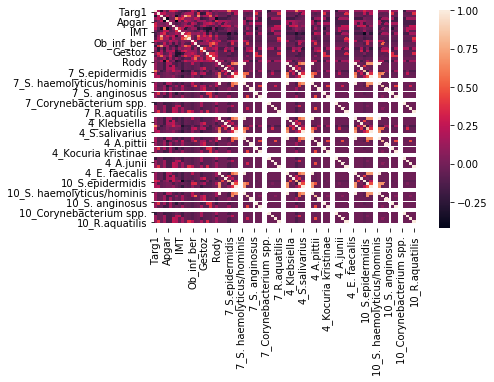

In [92]:
# drop - выбрасывает ненужные столбцы
corr_matrix = new_train.drop(['Targ3', 'Targ3'], axis=1).corr()
sns.heatmap(corr_matrix)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F17520B00>,
      dtype=object)

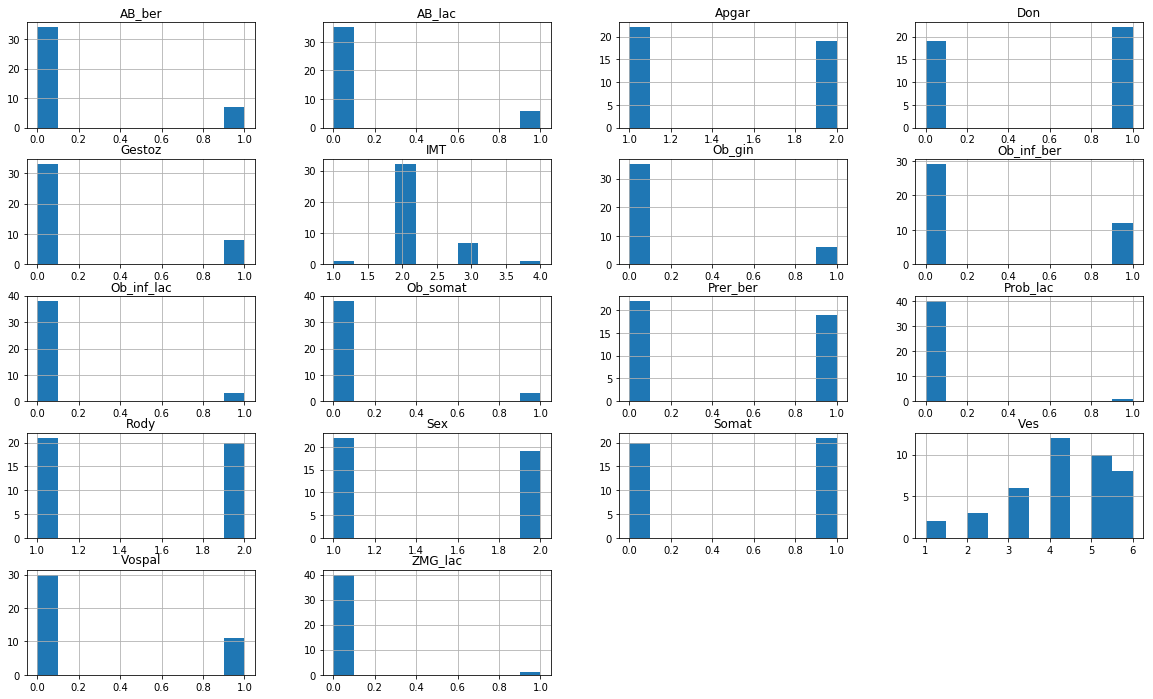

In [93]:
# Теперь посмотрим на распределения всех интересующих нас количественных признаков.
features = list(["Don","Apgar","Sex","Vospal","Ves",
                "IMT","Somat","Ob_somat","Ob_gin","Ob_inf_ber","Ob_inf_lac","ZMG_lac",
                "Prer_ber","Gestoz","AB_ber","AB_lac","Prob_lac","Rody"])
new_train[features].hist(figsize=(20,12))

Видим, что признаки распределены не нормально.

In [95]:
portret_cols = ["Don","Apgar","Sex","Vospal","Ves",
                "IMT","Somat","Ob_somat","Ob_gin","Ob_inf_ber","Ob_inf_lac","ZMG_lac",
                "Prer_ber","Gestoz","AB_ber","AB_lac","Prob_lac","Rody"]

In [1]:
# диаграммы рассеяния для пар признаков
#sns.pairplot(new_train[features + ['Rody']], hue='Targ2')

In [21]:
#new_train[numeric_cols].groupby('Targ2').sum().plot(kind='bar', rot=0)

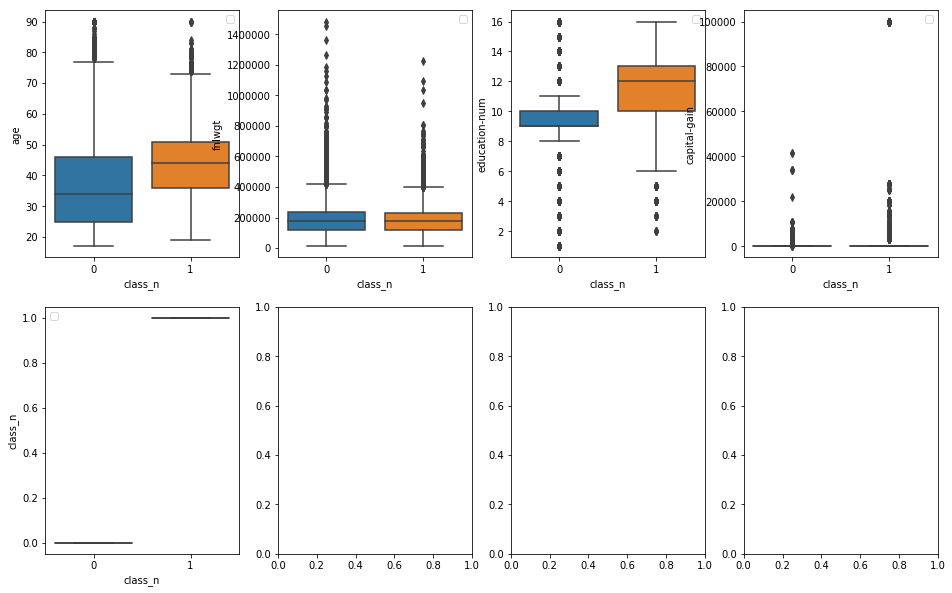

In [155]:
# Построим boxplot-ы, описывающее статистики распределения количественных признаков в двух группах: среди <=50 и >50.
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))

for idx, feat in  enumerate(features):
    sns.boxplot(x='class_n', y=feat, data=new_train, ax=axes[idx / 4, idx % 4])
    axes[idx / 4, idx % 4].legend()
    axes[idx / 4, idx % 4].set_xlabel('class_n')
    axes[idx / 4, idx % 4].set_ylabel(feat);

На глаз наибольшее отличие мы видим для признаков age и education.

Посмотрим отдельно на картинки с распределением кол-ва лет среди <=50 и >50. Слева — знакомые нам боксплоты, справа – сглаженные гистограммы распределения числового признака в двух группах (скорее просто красивая картинка, все и так понятно по боксплоту).

C:\ProgramData\Anaconda2\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


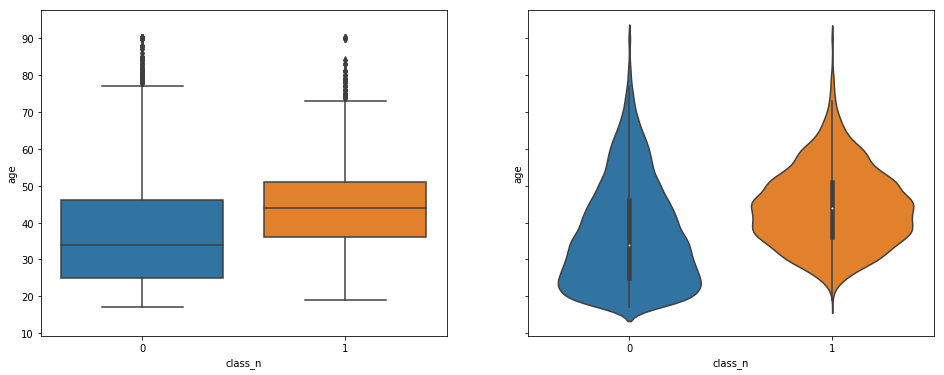

In [134]:
_, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))

sns.boxplot(x='class_n', y='age', data=new_train, ax=axes[0]);
sns.violinplot(x='class_n', y='age', data=new_train, ax=axes[1]);

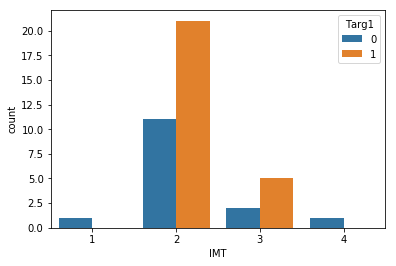

In [23]:
sns.countplot(x='IMT', hue='Targ1', data=new_train)

Вывод: Начиная с образования 14, доля получающих >50К выше, чем <=50К.

http://seaborn.pydata.org/api.html

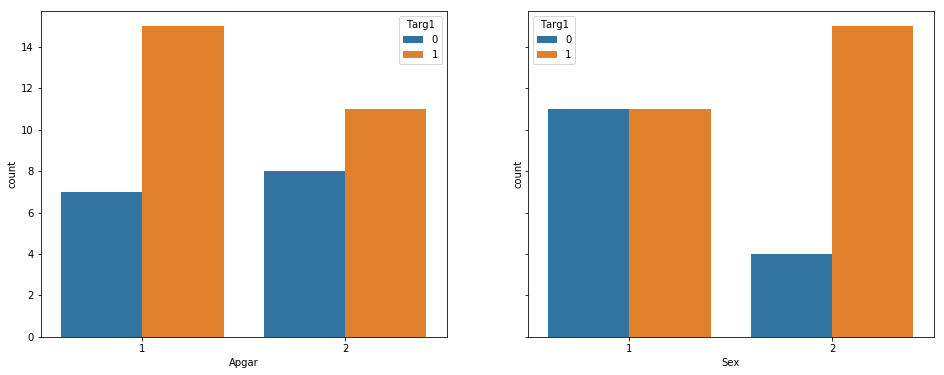

In [26]:
 _, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.countplot(x='Apgar', hue='Targ1', data=new_train, ax=axes[0]);
sns.countplot(x='Sex', hue='Targ1', data=new_train, ax=axes[1]);

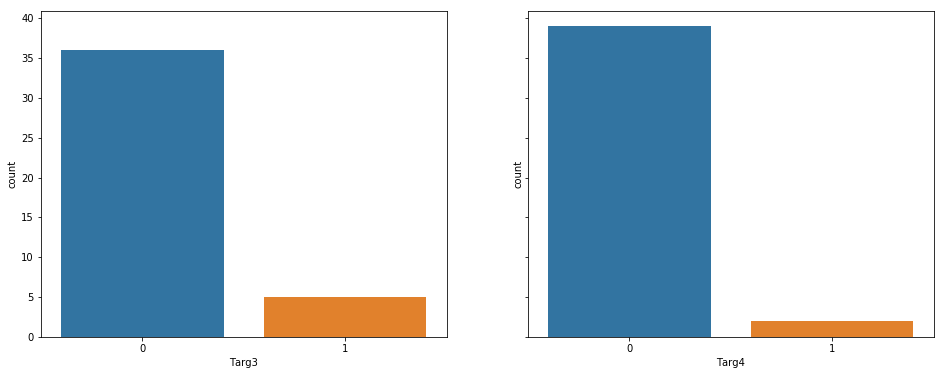

In [27]:
 _, axes = plt.subplots(1, 2, sharey=True, figsize=(16,6))
sns.countplot(x="Targ3", data=new_train, ax=axes[0])
sns.countplot(x="Targ4", data=new_train, ax=axes[1])

# продолжить от сюда
примерно с половины
https://habr.com/ru/company/ods/blog/323210/

In [57]:
new_train[numeric_cols].mean()

Targ1         0.634146
Don           0.536585
Apgar         1.463415
Sex           1.463415
Vospal        0.268293
Ves           4.195122
IMT           2.195122
Somat         0.512195
Ob_somat      0.073171
Ob_gin        0.146341
Ob_inf_ber    0.292683
Ob_inf_lac    0.073171
ZMG_lac       0.024390
Prer_ber      0.463415
Gestoz        0.195122
AB_ber        0.170732
AB_lac        0.146341
Prob_lac      0.024390
Rody          1.487805
dtype: float64

In [58]:
import seaborn as sns

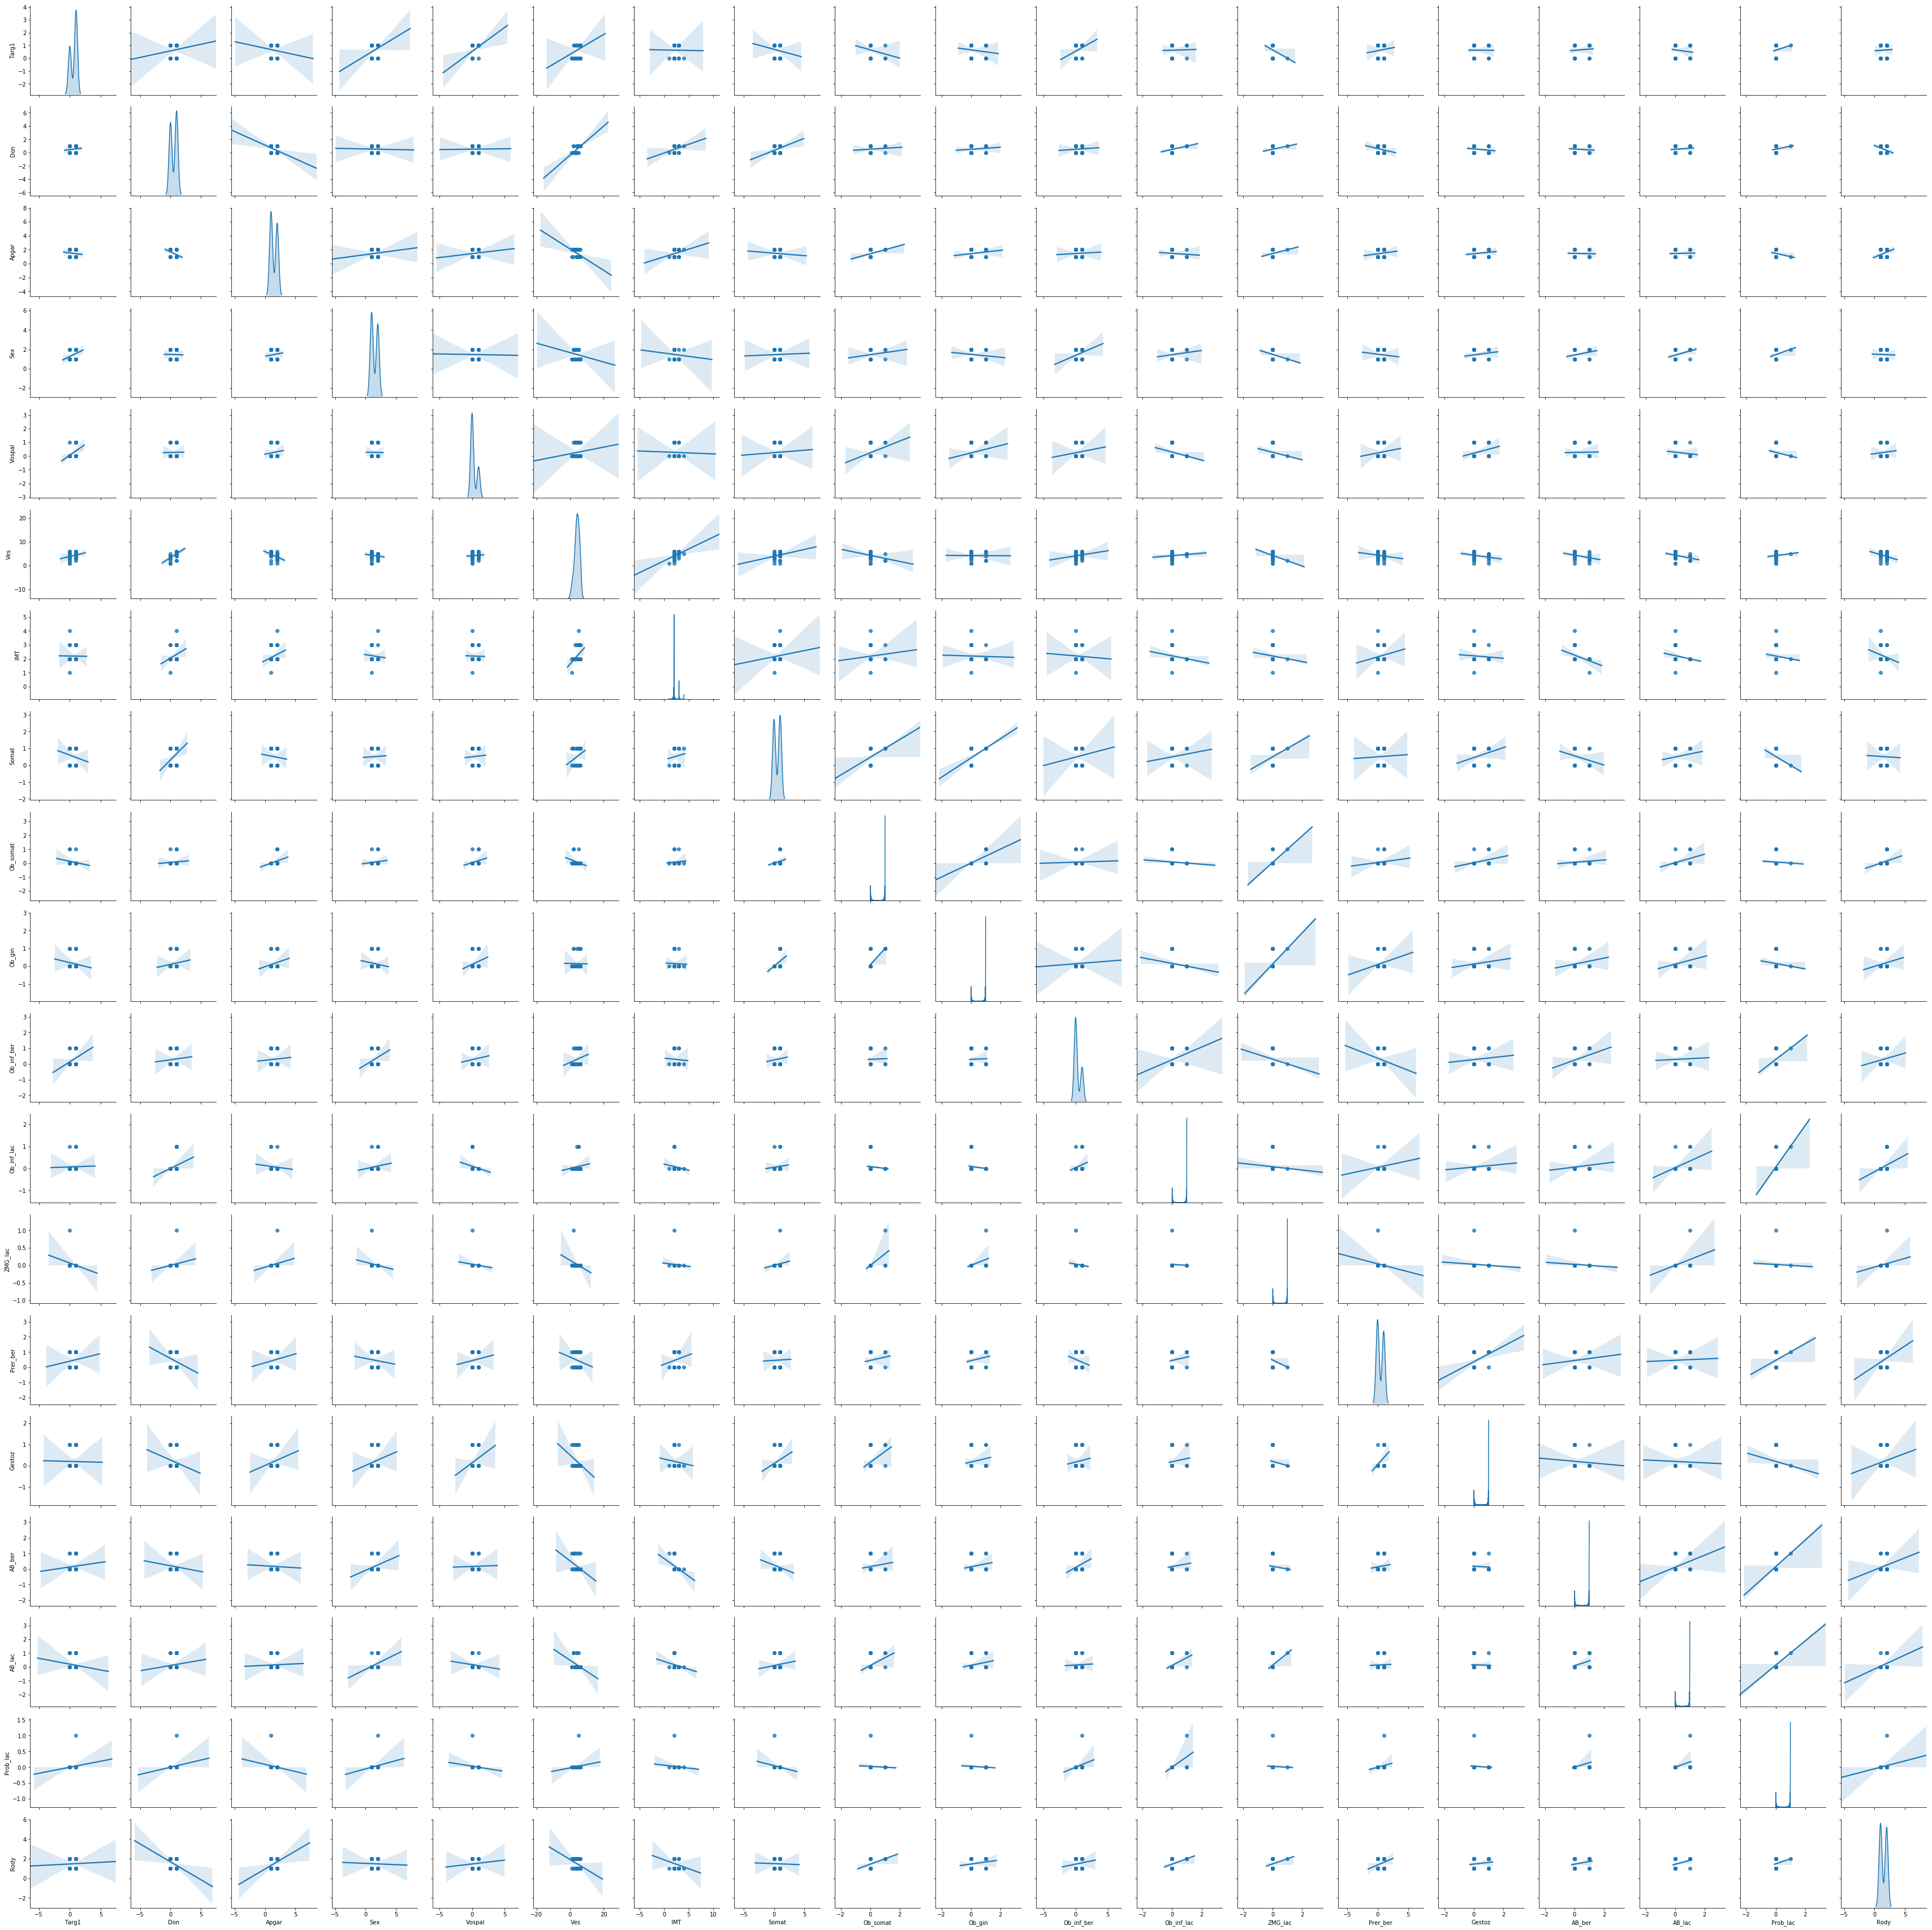

In [60]:
sns.pairplot(new_train[numeric_cols], palette="husl",diag_kind="kde",kind="reg");
plt.show()

# случайный лес (ensemble.RandomForestClassifier) из sklearn. 
Во втором при фиксированном числе деревьев в 50 подберите  𝑚𝑎𝑥_𝑑𝑒𝑝𝑡ℎ  и  𝑚𝑖𝑛_𝑠𝑎𝑚𝑝𝑙𝑒𝑠_𝑠𝑝𝑙𝑖𝑡  из отрезка  [2,14]  с шагом в 2 и множества  {1,2,4,8}  соответственно. За целевую метрику качества возьмите AUC-ROC. В качестве схемы валидации используйте стратифицированную кросс-валидацию по 5-ти фолдам. Какие параметры оказались оптимальными?

статья про случайный лес: https://dyakonov.org/2016/11/14/случайный-лес-random-forest/

Для классификации реализованы критерии “gini” и “entropy”.

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [62]:
# используйте стратифицированную кросс-валидацию по 5-ти фолдам
cv=5

In [63]:
rfcs = [RandomForestClassifier(max_depth=2,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=2,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=2,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=2,min_samples_split=8, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=4,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=4,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=4,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=4,min_samples_split=8, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=6,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=6,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=6,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=6,min_samples_split=8, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=8,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=8,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=8,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=8,min_samples_split=8, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=10,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=10,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=10,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=10,min_samples_split=8, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=12,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=12,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=12,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=12,min_samples_split=8, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=14,min_samples_split=2, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=14,min_samples_split=3, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=14,min_samples_split=4, n_estimators=50, random_state=10),
        RandomForestClassifier(max_depth=14,min_samples_split=8, n_estimators=50, random_state=10)]

In [64]:
type(rfcs[0])

sklearn.ensemble.forest.RandomForestClassifier

In [65]:
rfcs_x = np.array(['max_depth=2,min_samples_split=2',
                   'max_depth=2,min_samples_split=3',
                   'max_depth=2,min_samples_split=4',
                   'max_depth=2,min_samples_split=8',
                   'max_depth=4,min_samples_split=2',
                   'max_depth=4,min_samples_split=3',
                   'max_depth=4,min_samples_split=4',
                   'max_depth=4,min_samples_split=8',
                   'max_depth=6,min_samples_split=2',
                   'max_depth=6,min_samples_split=3',
                   'max_depth=6,min_samples_split=4',
                   'max_depth=6,min_samples_split=8',
                   'max_depth=8,min_samples_split=2',
                   'max_depth=8,min_samples_split=3',
                   'max_depth=8,min_samples_split=4',
                   'max_depth=8,min_samples_split=8',
                   'max_depth=10,min_samples_split=2',
                   'max_depth=10,min_samples_split=3',
                   'max_depth=10,min_samples_split=4',
                   'max_depth=10,min_samples_split=8',
                   'max_depth=12,min_samples_split=2',
                   'max_depth=12,min_samples_split=3',
                   'max_depth=12,min_samples_split=4',
                   'max_depth=12,min_samples_split=8',
                   'max_depth=14,min_samples_split=2',
                   'max_depth=14,min_samples_split=3',
                   'max_depth=14,min_samples_split=4',
                   'max_depth=14,min_samples_split=8'])

In [66]:
rfcs_n = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28])
len(rfcs_n)

28

In [67]:
rfcs_n.shape

(28,)

In [68]:
s=len(rfcs_n)
train_rfc_Accuracy = np.zeros(s)
train_rfc_Precision = np.zeros(s)
train_rfc_Recall = np.zeros(s)
train_rfc_Roc_auc = np.zeros(s)
train_rfc_F1 = np.zeros(s)

In [152]:
#new_train[numeric_cols_Y]

In [39]:
# обучение
#model = RandomForestClassifier(max_depth=6,min_samples_split=8, n_estimators=50, random_state=10)
#model.fit (new_train[numeric_cols_X], new_train[numeric_cols_Y])
#score = np.mean(cross_val_score(model, new_train[numeric_cols_X], new_train[numeric_cols_Y], scoring = 'roc_auc', cv = cv)) 


In [69]:
for j, rfc in enumerate(rfcs):
    #print (j, rfc)
    rfc.fit(new_train[numeric_cols_X], new_train[numeric_cols_Y])
    train_rfc_Accuracy[j] = np.mean(cross_val_score(rfc, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='accuracy'))
    train_rfc_Precision[j] = np.mean(cross_val_score(rfc, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='precision'))
    train_rfc_Recall[j] = np.mean(cross_val_score(rfc, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='recall'))
    train_rfc_Roc_auc[j] = np.mean(cross_val_score(rfc, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='roc_auc'))
    train_rfc_F1[j] = np.mean(cross_val_score(rfc, X=new_train[numeric_cols_X], y=new_train[numeric_cols_Y], scoring='f1'))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the def

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the def

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shap

In [70]:
max_rfc_Roc_auc = max(train_rfc_Roc_auc)
ind_rfc_Roc_auc = np.where(train_rfc_Roc_auc == max_rfc_Roc_auc)
#IA = int(ind_Roc_auc[0][0])
#print(len(ind_Roc_auc[0]))
for a, b in enumerate(ind_rfc_Roc_auc[0]):
    #print('a= ', a, 'b= ',b)
    print ('Optimal method: ' + str (b) + ' ' + str(rfcs_x[b]) + ' Roc_auc = '+ str(max_rfc_Roc_auc))

Optimal method: 12 max_depth=8,min_samples_split=2 Roc_auc = 0.5856481481481481


Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0.5, 1.0, 'Choosing Optimal method')

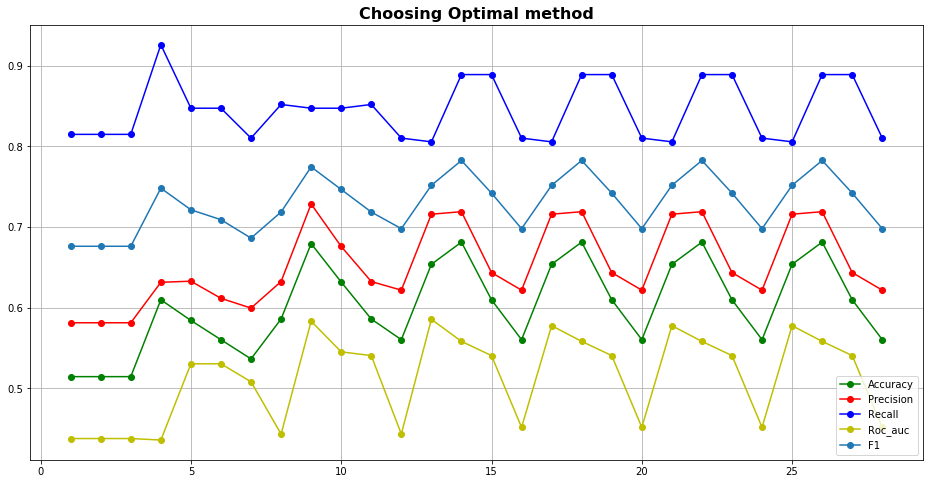

In [71]:
%pylab inline
fig, ax = plt.subplots(figsize=(16,8))
pylab.grid(True)
pylab.plot(rfcs_n, train_rfc_Accuracy, 'g-', marker='o', label='Accuracy')
pylab.plot(rfcs_n, train_rfc_Precision, 'r-', marker='o', label='Precision')
pylab.plot(rfcs_n, train_rfc_Recall, 'b-', marker='o', label='Recall')
pylab.plot(rfcs_n, train_rfc_Roc_auc, 'y-', marker='o', label='Roc_auc')
pylab.plot(rfcs_n, train_rfc_F1, 'p-', marker='o', label='F1')
#pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')
ax.set_title('Choosing Optimal method', fontsize = 16, fontweight='bold', color='black')

In [72]:
s=len(rfcs)
train_rfc_Accuracy_p = np.zeros(s)
train_rfc_Precision_p = np.zeros(s)
train_rfc_Recall_p = np.zeros(s)
train_rfc_Roc_auc_p = np.zeros(s)
train_rfc_F1_p = np.zeros(s)

In [73]:
for j, rfc in enumerate(rfcs):
    print (j, rfc)
    prediction = rfc.predict(new_test[numeric_cols_X])
    #rfc.fit(new_train[numeric_cols_X], new_train[numeric_cols_Y])
    #Измерение точности предсказания - доля
    train_rfc_Accuracy_p[j] = np.mean(accuracy_score(new_test[numeric_cols_Y], prediction))
    train_rfc_Precision_p[j] = np.mean(precision_score(new_test[numeric_cols_Y], prediction))
    train_rfc_Recall_p[j] = np.mean(recall_score(new_test[numeric_cols_Y], prediction))
    train_rfc_Roc_auc_p[j] = np.mean(roc_auc_score(new_test[numeric_cols_Y], prediction))
    train_rfc_F1_p[j] = np.mean(f1_score(new_test[numeric_cols_Y], prediction))
    print('accuracy: ', train_rfc_Accuracy_p[j])
    print('precision: ', train_rfc_Precision_p[j])
    print('recall: ', train_rfc_Recall_p[j])
    print('roc_auc: ', train_rfc_Roc_auc_p[j])
    print('F1: ', train_rfc_F1_p[j])

0 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)
accuracy:  0.4
precision:  0.35294117647058826
recall:  0.8571428571428571
roc_auc:  0.5054945054945055
F1:  0.5
1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)
accuracy:  0.35
precision:  0.3125
recall:  0.7142857142857143
roc_au

accuracy:  0.45
precision:  0.3333333333333333
recall:  0.5714285714285714
roc_auc:  0.478021978021978
F1:  0.4210526315789474
17 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)
accuracy:  0.35
precision:  0.25
recall:  0.42857142857142855
roc_auc:  0.36813186813186816
F1:  0.3157894736842105
18 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
          

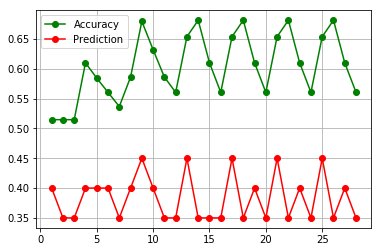

In [74]:
fig, ax = plt.subplots(figsize=(6,4))
pylab.grid(True)
pylab.plot(rfcs_n, train_rfc_Accuracy, 'g-', marker='o', label='Accuracy')
pylab.plot(rfcs_n, train_rfc_Accuracy_p, 'r-', marker='o', label='Prediction')
pylab.legend()

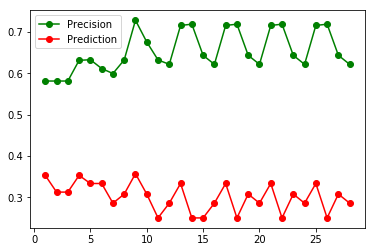

In [75]:
pylab.plot(rfcs_n, train_rfc_Precision, 'g-', marker='o', label='Precision')
pylab.plot(rfcs_n, train_rfc_Precision_p, 'r-', marker='o', label='Prediction')
pylab.legend()

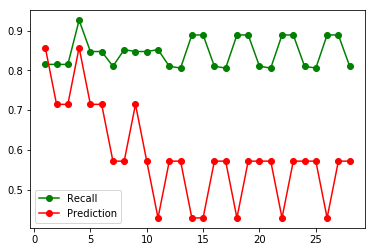

In [76]:
pylab.plot(rfcs_n, train_rfc_Recall, 'g-', marker='o', label='Recall')
pylab.plot(rfcs_n, train_rfc_Recall_p, 'r-', marker='o', label='Prediction')
pylab.legend()

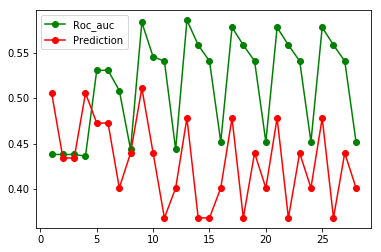

In [77]:
pylab.plot(rfcs_n, train_rfc_Roc_auc, 'g-', marker='o', label='Roc_auc')
pylab.plot(rfcs_n, train_rfc_Roc_auc_p, 'r-', marker='o', label='Prediction')
pylab.legend()

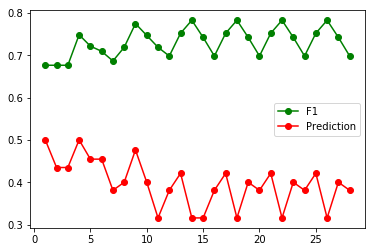

In [78]:
pylab.plot(rfcs_n, train_rfc_F1, 'g-', marker='o', label='F1')
pylab.plot(rfcs_n, train_rfc_F1_p, 'r-', marker='o', label='Prediction')
pylab.legend()

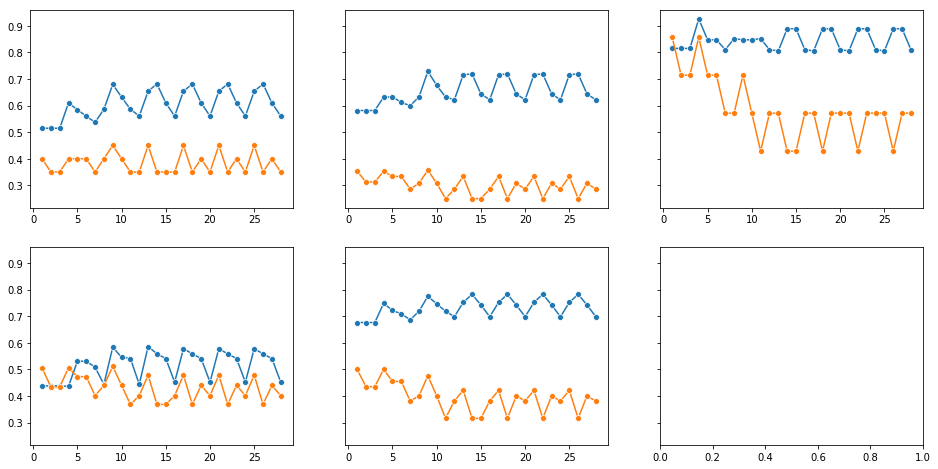

In [79]:
 _, axes = plt.subplots(2, 3, sharey=True, figsize=(16,8))

sns.lineplot(rfcs_n, train_rfc_Accuracy, marker='o', legend='full', ax=axes[0][0])
sns.lineplot(rfcs_n, train_rfc_Accuracy_p, marker='o', legend='full', ax=axes[0][0])

sns.lineplot(rfcs_n, train_rfc_Precision, marker='o', legend='full', ax=axes[0][1])
sns.lineplot(rfcs_n, train_rfc_Precision_p, marker='o', legend='full', ax=axes[0][1])

sns.lineplot(rfcs_n, train_rfc_Recall, marker='o', legend='full', ax=axes[0][2])
sns.lineplot(rfcs_n, train_rfc_Recall_p, marker='o', legend='full', ax=axes[0][2])

sns.lineplot(rfcs_n, train_rfc_Roc_auc, marker='o', legend='full', ax=axes[1][0])
sns.lineplot(rfcs_n, train_rfc_Roc_auc_p, marker='o', legend='full', ax=axes[1][0])

sns.lineplot(rfcs_n, train_rfc_F1, marker='o', legend='full', ax=axes[1][1])
sns.lineplot(rfcs_n, train_rfc_F1_p, marker='o', legend='full', ax=axes[1][1])


plt.show();

В медицинских исследованиях точность измеряется полнота(recall)=TP/(TP+FN)

В банковских исследованиях точность измеряется точность(precision)=TP/(TP+FP)

# Строительство деревьев

https://nuancesprog.ru/p/1257/

In [ ]:
model = RandomForestClassifier(max_depth=2,min_samples_split=8, n_estimators=50, random_state=10)

model.fit(X, y)

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [118]:
import numpy as np
import pandas as pd
import math

In [111]:
column_names = ["Targ1","Targ2","Targ3","Targ4","Don","Apgar","Sex","Vospal","Ves",
                "IMT","Somat","Ob_somat","Ob_gin","Ob_inf_ber","Ob_inf_lac","ZMG_lac",
                "Prer_ber","Gestoz","AB_ber","AB_lac","Prob_lac","Rody","7_St aureus","7_Klebsiella","7_E.Coli",
                "7_S.epidermidis","7_Enterococcus spp.","7_S.salivarius","7_K.pneumoniae","7_S. haemolyticus/hominis",
                "7_S. lugdunensis","7_A.pittii","7_S. agalactiae","7_S. anginosus","7_A. baumannii","7_Kocuria kristinae",
                "7_Rothia spp.","7_Corynebacterium spp.","7_Enterobacter spp.","7_A.junii","7_S.maltophilia","7_R.aquatilis",
                "7_Pseudomonas spp","7_E. faecalis","4_St aureus","4_Klebsiella","4_E.Coli","4_S.epidermidis",
                "4_Enterococcus spp.","4_S.salivarius","4_K.pneumoniae","4_S. haemolyticus/hominis",
                "4_S. lugdunensis ","4_A.pittii","4_S. agalactiae","4_S. anginosus","4_A. baumannii","4_Kocuria kristinae",
                "4_Rothia spp.","4_Corynebacterium spp.","4_Enterobacter spp.","4_A.junii","4_S.maltophilia",
                "4_R.aquatilis","4_Pseudomonas spp","4_E. faecalis","10_St aureus","10_Klebsiella",
                "10_E.Coli","10_S.epidermidis","10_Enterococcus spp.","10_S.salivarius","10_K.pneumoniae",
                "10_S. haemolyticus/hominis","10_S. lugdunensis ","10_A.pittii","10_S. agalactiae",
                "10_S. anginosus","10_A. baumannii","10_Kocuria kristinae","10_Rothia spp.",
                "10_Corynebacterium spp.","10_Enterobacter spp.","10_A.junii","10_S.maltophilia",
                "10_R.aquatilis","10_Pseudomonas spp","10_E. faecalis"]

In [112]:
train = pd.read_csv("DM2_train.csv", sep=";", header=None, engine="python", names=column_names)

In [113]:
test = pd.read_csv("DM3_test.csv", sep=";", header=None, engine="python", names=column_names)

In [180]:
train_features = train[numeric_cols_X]
train_labels = train[numeric_cols_Y]
test_features = test[numeric_cols_X]
test_labels = test[numeric_cols_Y]

In [181]:
train_features.shape


(41, 18)

In [182]:
rf = RandomForestClassifier(max_depth=2,min_samples_split=8, n_estimators=50, random_state=10)
# Train the model on training data
rf.fit(train_features, train_labels)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [165]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [183]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
predictions

array([1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [184]:
type(predictions[0])

numpy.int64

In [185]:
test_labels_resh = np.array(test_labels).reshape((-1,))
test_labels_resh

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0],
      dtype=int64)

In [186]:
len(test_labels_resh)

20

In [187]:
numpy.float64(test_labels_resh)

array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 0.])

In [188]:
# Calculate the absolute errors
errors = abs(predictions - numpy.float64(test_labels_resh))
errors

array([1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 0., 1.])

In [189]:
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.6 degrees.


In [190]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels_resh)
mape


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([ inf,   0.,   0.,  inf,  nan,  inf,  inf, 100.,  inf,  nan,  inf,
         0.,   0.,   0.,  inf,  inf,  inf,  inf,   0.,  inf])

In [191]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: nan %.


In [160]:
#train_features = train[numeric_cols]


In [192]:
feature_list = list(train_features.columns)
feature_list

['Don',
 'Apgar',
 'Sex',
 'Vospal',
 'Ves',
 'IMT',
 'Somat',
 'Ob_somat',
 'Ob_gin',
 'Ob_inf_ber',
 'Ob_inf_lac',
 'ZMG_lac',
 'Prer_ber',
 'Gestoz',
 'AB_ber',
 'AB_lac',
 'Prob_lac',
 'Rody']

In [193]:
from sklearn import tree

# Extract a single tree (number 105)
single_tree = rf.estimators_[1]

# Save the tree to a dot file
tree.export_graphviz(single_tree, out_file = 'tree.dot', feature_names = feature_list)

#С помощью визуализатора Graphviz преобразуем dot-файл в png, введя в командной строке:

#dot -Tpng tree.dot -o tree.png

#Получили полное дерево решений:

http://webgraphviz.com

# Масштабирование входящих данных



2. Отмасштабировать данные с помощью StandartScaler'а из модуля preprocessing

In [80]:
new_train[numeric_cols].head()

,Targ1,Don,Apgar,Sex,Vospal,Ves,IMT,Somat,Ob_somat,Ob_gin,Ob_inf_ber,Ob_inf_lac,ZMG_lac,Prer_ber,Gestoz,AB_ber,AB_lac,Prob_lac,Rody
0,1,0,2,2,0,3,2,0,0,0,1,0,0,0,0,1,0,0,2
1,1,0,1,2,1,4,2,1,0,0,1,0,0,0,1,0,0,0,1
2,1,1,2,2,1,5,3,1,1,1,0,0,0,1,1,0,0,0,2
3,1,1,2,1,1,6,3,0,0,0,1,0,0,0,0,0,0,0,1
4,1,0,2,1,0,4,3,1,0,0,0,0,0,1,0,0,0,0,2


In [88]:
#статистика признаков - делается только по численным признакам
new_train[numeric_cols_X].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 18 columns):
Don           41 non-null int64
Apgar         41 non-null int64
Sex           41 non-null int64
Vospal        41 non-null int64
Ves           41 non-null int64
IMT           41 non-null int64
Somat         41 non-null int64
Ob_somat      41 non-null int64
Ob_gin        41 non-null int64
Ob_inf_ber    41 non-null int64
Ob_inf_lac    41 non-null int64
ZMG_lac       41 non-null int64
Prer_ber      41 non-null int64
Gestoz        41 non-null int64
AB_ber        41 non-null int64
AB_lac        41 non-null int64
Prob_lac      41 non-null int64
Rody          41 non-null int64
dtypes: int64(18)
memory usage: 5.8 KB


In [81]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(new_train[numeric_cols])
new_train_scaled = scaler.transform(new_train[numeric_cols])
#new_train_scaled

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


3. Произведите масштабирование признаков с помощью функции sklearn.preprocessing.scale.

In [91]:
new_train[numeric_cols].head()

,Targ1,Don,Apgar,Sex,Vospal,Ves,IMT,Somat,Ob_somat,Ob_gin,Ob_inf_ber,Ob_inf_lac,ZMG_lac,Prer_ber,Gestoz,AB_ber,AB_lac,Prob_lac,Rody
0,1,0,2,2,0,3,2,0,0,0,1,0,0,0,0,1,0,0,2
1,1,0,1,2,1,4,2,1,0,0,1,0,0,0,1,0,0,0,1
2,1,1,2,2,1,5,3,1,1,1,0,0,0,1,1,0,0,0,2
3,1,1,2,1,1,6,3,0,0,0,1,0,0,0,0,0,0,0,1
4,1,0,2,1,0,4,3,1,0,0,0,0,0,1,0,0,0,0,2


In [92]:
new_train_scaled

array([[ 0.75955453, -1.07605517,  1.07605517,  1.07605517, -0.60553007,
        -0.87527915, -0.3866946 , -1.02469508, -0.28097574, -0.41403934,
         1.55456318, -0.28097574, -0.15811388, -0.92932038, -0.49236596,
         2.20389266, -0.41403934, -0.15811388,  1.02469508],
       [ 0.75955453, -1.07605517, -0.92932038,  1.07605517,  1.65144565,
        -0.14290272, -0.3866946 ,  0.97590007, -0.28097574, -0.41403934,
         1.55456318, -0.28097574, -0.15811388, -0.92932038,  2.0310096 ,
        -0.45374261, -0.41403934, -0.15811388, -0.97590007],
       [ 0.75955453,  0.92932038,  1.07605517,  1.07605517,  1.65144565,
         0.58947371,  1.59511521,  0.97590007,  3.55902608,  2.41522946,
        -0.64326752, -0.28097574, -0.15811388,  1.07605517,  2.0310096 ,
        -0.45374261, -0.41403934, -0.15811388,  1.02469508],
       [ 0.75955453,  0.92932038,  1.07605517, -0.92932038,  1.65144565,
         1.32185015,  1.59511521, -1.02469508, -0.28097574, -0.41403934,
         1.554

### 3. Категориальные признаки как есть

Теперь к вещественным добавьте категориальные признаки, заменив их на числа с помощью LabelEncoder из модуля preprocessing. Переподберите параметры для логистической регрессии и случайного леса аналогично прошлому пункту. Как изменилось качество моделей на тестовой выборке? Как вы можете это объяснить?

In [93]:
from sklearn.preprocessing import LabelEncoder

In [71]:
new_train[categorical_cols].head()

,workclass,education,class,marital-status,occupation,race,native-country,relationship,sex
0,State-gov,Bachelors,<=50K,Never-married,Adm-clerical,White,United-States,Not-in-family,Male
1,Self-emp-not-inc,Bachelors,<=50K,Married-civ-spouse,Exec-managerial,White,United-States,Husband,Male
2,Private,HS-grad,<=50K,Divorced,Handlers-cleaners,White,United-States,Not-in-family,Male
3,Private,11th,<=50K,Married-civ-spouse,Handlers-cleaners,Black,United-States,Husband,Male
4,Private,Bachelors,<=50K,Married-civ-spouse,Prof-specialty,Black,Cuba,Wife,Female


In [72]:
categorical_cols_X = ['workclass',
 'relationship',
 'sex',
 'race',
 'native-country',
 'education',
 'marital-status',
 'occupation']
categorical_cols_X

['workclass',
 'relationship',
 'sex',
 'race',
 'native-country',
 'education',
 'marital-status',
 'occupation']

In [73]:
new_train_LE = new_train.copy()
new_test_LE = new_test.copy()
new_test_LE[categorical_cols_X].head()

,workclass,relationship,sex,race,native-country,education,marital-status,occupation
0,Private,Own-child,Male,Black,United-States,11th,Never-married,Machine-op-inspct
1,Private,Husband,Male,White,United-States,HS-grad,Married-civ-spouse,Farming-fishing
2,Local-gov,Husband,Male,White,United-States,Assoc-acdm,Married-civ-spouse,Protective-serv
3,Private,Husband,Male,Black,United-States,Some-college,Married-civ-spouse,Machine-op-inspct
4,New group,Own-child,Female,White,United-States,Some-college,Never-married,New group


In [32]:
for column in list(categorical_cols_X):
    le = LabelEncoder()
    new_train_LE[column] = le.fit_transform(new_train_LE[column])
    new_test_LE[column] = le.fit_transform(new_test_LE[column])
    #print (new_train_LE[column])
    #print (new_test_LE[column])

In [33]:
new_train_LED = new_train_LE.drop(['class'], axis=1)
new_test_LED = new_test_LE.drop(['class'], axis=1)

In [58]:
new_train_LED.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class_n
0,39,7,77516,9,13,4,0,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,3,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,5,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,5,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,4,0


НОРМАЛИЗАЦИЯ

In [59]:
from sklearn.preprocessing import StandardScaler

In [73]:
new_train_LED_X = new_train_LED.iloc[:,0:14]
new_train_LED_Y = new_train_LED.iloc[:,-1]
new_train_LED_X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,7,77516,9,13,4,0,1,4,1,2174,0,40,39
1,50,6,83311,9,13,2,3,0,4,1,0,0,13,39
2,38,4,215646,11,9,0,5,1,4,1,0,0,40,39
3,53,4,234721,1,7,2,5,0,2,1,0,0,40,39
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,4


In [74]:
new_test_LED_X = new_test_LED.iloc[:,0:14]
new_test_LED_Y = new_test_LED.iloc[:,-1]
new_test_LED_X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,4,226802,1,7,4,6,3,2,1,0,0,40,38
1,38,4,89814,11,9,2,4,0,4,1,0,0,50,38
2,28,1,336951,7,12,2,11,0,4,1,0,0,40,38
3,44,4,160323,15,10,2,6,0,2,1,7688,0,40,38
4,18,3,103497,15,10,4,7,3,4,0,0,0,30,38


In [75]:
scaler = StandardScaler()

In [76]:
new_train_LED_XS = scaler.fit_transform(new_train_LED_X)
new_test_LED_XS = scaler.fit_transform(new_test_LED_X)

C:\Users\shchepkina-ev\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shchepkina-ev\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\shchepkina-ev\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\shchepkina-ev\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [87]:
#new_train_LED_XS

In [86]:
#type(new_train_LED_XS)

In [78]:
#new_train_LED_Y

In [91]:
new_train_LED_Y_tr = (np.asarray(new_train_LED_Y)).ravel()
new_test_LED_Y_tr = (np.asarray(new_test_LED_Y)).ravel()
#new_train_LED_Y_tr

In [92]:
new_train_LED_Y_tr_p = (np.asarray(new_train_LED_Y_tr)).reshape(-1, 1)
new_test_LED_Y_tr_p = (np.asarray(new_test_LED_Y_tr)).reshape(-1, 1)
#new_train_LED_Y_tr_p

In [90]:
#type(new_train_LED_Y_tr_p)

In [94]:
new_train_1S = np.concatenate([new_train_LED_XS, new_train_LED_Y_tr_p], axis=1)
new_test_1S = np.concatenate([new_test_LED_XS, new_test_LED_Y_tr_p], axis=1)

In [95]:
np.savetxt('train_data_1S.csv',new_train_1S, fmt='%f')
np.savetxt('test_data_1S.csv',new_test_1S, fmt='%f')

### 4. Бинарное кодирование категориальных признаков

А теперь замените категориальные признаки из прошлого пункта на бинарно закодированные. Опять переподберите параметры для моделей и проверьте качество на тестовой выборке. Как изменилось качество относительно предыдущего пункта? Как вы можете это объяснить?